* 2024 기계학습특론 _ 윤지은) Style-Based Transformer for Time Series Forecasting 코드 구현


In [40]:
# 필요한 라이브러리 임포트
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import MinMaxScaler
import time

In [41]:
# 데이터셋 클래스 정의 - 데이터 전처리
class TimeSeriesDataset(Dataset):
    def __init__(
        self, path, sequence_len=30, output_len=30, sliding_window=1, client=None
    ):
        self.sequence_len = sequence_len
        self.output_len = output_len
        self.sliding_window = sliding_window

        # 데이터 로드 및 전처리
        data = pd.read_csv(path, sep=";", decimal=",")
        data = data.iloc[35040:, 1:322] # n_clients = 321 & 0 제거
        data = data.groupby(data.index // 4).sum() # 논문의 electricity 참조 참고 (1시간 간격으로 합산해 계산)
        data = torch.FloatTensor(data.to_numpy())  # (total_seq_len, feature_len)

        

        if client is not None:
            data = data[:, client : client + 1]

        # 데이터 정규화
        scaler = MinMaxScaler()
        data = torch.FloatTensor(scaler.fit_transform(data))

        # 나중에 역변환을 위해 scaler 저장
        self.scaler = scaler

        total_seq_len, feature_len = data.shape
        self.feature_len = feature_len

        # sliding window를 사용하여 데이터 생성
        x_indices = []
        y_indices = []

        for i in range(
            0, total_seq_len - sequence_len - output_len + 1, sliding_window
        ):
            x_indices.append(slice(i, i + sequence_len))
            y_indices.append(slice(i + sequence_len, i + sequence_len + output_len))

        # 데이터 분리
        self.data_x = torch.stack(
            [data[x_idx] for x_idx in x_indices]
        )  # (data_size, sequence_len, feature_len)
        self.data_y = torch.stack(
            [data[y_idx] for y_idx in y_indices]
        )  # (data_size, output_len, feature_len)

    def __len__(self):
        return len(self.data_x)

    def __getitem__(self, idx):
        return self.data_x[idx], self.data_y[idx]

In [42]:
# 디코더에 들어갈 latent vector (초기 시계열 순차)를 구하는 함수 - 논문 eq.8
def calculate_linear_regression_parallel(x):
    # x: (sequence_len, batch_size, feature_len)

    m = x.shape[0]
    x_mean = x.sum(dim=0, keepdim=False) / m  # (batch_size, feature_len)

    # 기울기 계산
    numerator = torch.zeros_like(x_mean)  # (batch_size, feature_len)
    for i in range(m):
        numerator += (i + 1 - m / 2) * (
            x[i, :, :] - x_mean
        )  # (batch_size, feature_len)

    # 최소 제곱법에 의한 기울기 계산
    a = ((12 / (m**3 + 2 * m)) * numerator).unsqueeze(0)  # (1, batch_size, feature_len)

    # y절편 계산
    b = x_mean.unsqueeze(0) - a * (m / 2)  # (1, batch_size, feature_len)

    return (x * a) + b  # (sequence_len, batch_size, feature_len)

In [43]:
# positional encoding 모듈 정의
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500, device="cuda"):
        super().__init__()

        self.PE = torch.zeros(max_len, d_model, device=device)
        self.PE.requires_grad = False

        pos = torch.arange(0, max_len, dtype=torch.float, device=device).unsqueeze(
            dim=1
        )
        interval = torch.arange(0, d_model, step=2, dtype=torch.float, device=device)

        self.PE[:, 0::2] = torch.sin(pos / 10000 ** (interval / d_model))
        self.PE[:, 1::2] = torch.cos(pos / 10000 ** (interval / d_model))

    def forward(self, x):
        # x: (sequence_len, batch_size, feature_len)
        sequence_len, batch_size, feature_len = x.shape
        return x + self.PE[:sequence_len, :].unsqueeze(1)

In [44]:
# AdaIN (Adaptive Instance Normalization) - 논문 eq.9
class AdaIN(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, style):
        # (output_seq_len:n, batch_size, feature_len), (sequence_len, batch_size, 1)

        x_mean = torch.mean(x, dim=0, keepdim=True)
        x_std = torch.std(x, dim=0, keepdim=True) + 1e-7
        style_mean = torch.mean(style, dim=0, keepdim=True)
        style_std = torch.std(style, dim=0, keepdim=True) + 1e-7

        # (output_seq_len:n, batch_size, feature_len)
        normalized_content = (x - x_mean) / x_std
        return normalized_content * style_std + style_mean

In [45]:
# 인코더 모듈 정의
class Encoder(nn.Module):
    def __init__(self, feature_len):
        super().__init__()

        d_model = 4  # 논문 고정 값.

        self.input_projection = nn.Linear(feature_len, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        # 첫 번째 레이어 (d_model -> d_model//2)
        encoder_layer1 = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=2  # nhead는 d_model의 약수여야 함
        )
        self.transformer_encoder1 = nn.TransformerEncoder(encoder_layer1, num_layers=1)
        self.projection1 = nn.Linear(d_model, d_model // 2)

        # 두 번째 레이어 (d_model//2 -> d_model//4 == 1)
        encoder_layer2 = nn.TransformerEncoderLayer(
            d_model=d_model // 2, nhead=1  # nhead는 d_model의 약수여야 함
        )
        self.transformer_encoder2 = nn.TransformerEncoder(encoder_layer2, num_layers=1)
        self.projection2 = nn.Linear(d_model // 2, d_model // 4)  # (.., 1)

    def forward(self, src):
        # 입력 프로젝션
        # src: (sequence_len, batch_size, feature_len)
        x = self.input_projection(src)  # (sequence_len, batch_size, d_model)
        x = self.pos_encoder(x)  # (sequence_len, batch_size, 4)

        # 첫 번째 레이어
        x = self.transformer_encoder1(x)  # (sequence_len, batch_size, 4)
        x = self.projection1(x)  # (sequence_len, batch_size, 2)

        # 두 번째 레이어
        x = self.transformer_encoder2(x)  # (sequence_len, batch_size, 2)
        x = self.projection2(x)  # (sequence_len, batch_size, 1)

        return x  # style: (sequence_len, batch_size, 1)

In [46]:
# 디코더 모듈 정의
class StyleBasedDecoder(nn.Module):
    def __init__(self, output_seq_len, feature_len, num_layers=6):
        super().__init__()
        self.num_layers = num_layers
        self.adain_layers = nn.ModuleList([AdaIN() for _ in range(num_layers)])
        self.conv_layers = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv1d(feature_len, feature_len, kernel_size=3, stride=1, padding=1),
                    nn.ReLU() 
                )
                for _ in range(num_layers)
            ]
        )

        self.last_fpn_layer = nn.Sequential(
            nn.Linear(output_seq_len * feature_len, output_seq_len * feature_len *4),
            nn.ReLU(), 
            nn.Linear(output_seq_len * feature_len * 4, output_seq_len * feature_len)
        )

    def forward(self, origin_x, x, style):

        for i in range(self.num_layers):

            # (output_seq_len:n, batch_size, feature_len)
            adain_x = self.adain_layers[i](x, style)

            # return to (output_seq_len:n, batch_size, feature_len)
            conv_x = self.conv_layers[i](adain_x.permute(1, 2, 0)).permute(2, 0, 1)

            # add adain_x as residual # (output_seq_len:n, batch_size, feature_len)
            x = conv_x + adain_x

            # 입력 origin_x에 대한 axis 1에 대한 표준편차를 구하고 이를 기반으로 노이즈 생성
            std = torch.std(origin_x, dim=0, keepdim=True)
            noise = torch.randn_like(x) * std

            # add noise
            x += noise 

        # last FPN layer
        output_seq_len, batch_size, feature_len = x.shape
        x = x.permute(1, 0, 2).reshape(batch_size, -1)
        x = self.last_fpn_layer(x)  # Apply FCN
        x = x.reshape(batch_size, output_seq_len, feature_len).permute(1, 0, 2)

        return x  # (output_seq_len:n, batch_size, feature_len)

In [47]:
# 전체 모델
class StyleBasedTransformer(nn.Module):
    def __init__(self, feature_len, output_seq_len):
        super().__init__()
        self.output_seq_len = output_seq_len
        self.encoder = Encoder(
            feature_len,
        )  # layer 고정.
        self.decoder = StyleBasedDecoder(
            output_seq_len=self.output_seq_len, feature_len=feature_len, num_layers=6
        )

    def forward(self, x):
        # (seqence_len, batch_size, 1)
        style = self.encoder(x)

        # 임의 초기 시계열 값. eq.8.  # (output_seq_len:n, batch_size, feature_len)
        initial_timeseries = calculate_linear_regression_parallel(x)[
            : self.output_seq_len, :, :
        ]

        # (output_seq_len:n, batch_size, feature_len)
        pred = self.decoder(origin_x=x, x=initial_timeseries, style=style)
        return pred

In [48]:
# 평가 지표 계산하는 함수 정의 - RMSE, Corr, 논문 eq.10
def calculate_metrics(y_true, y_pred):
    # (time_seq, feature_len)
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2, axis=0))

    y_true_mean = np.mean(y_true, axis = 0)
    y_pred_mean = np.mean(y_pred, axis = 0)

    numerator = np.sum((y_true - y_true_mean) * (y_pred - y_pred_mean), axis = 0)
    denominator = (
        np.sqrt(np.sum((y_true - y_true_mean) ** 2, axis=0) * np.sum((y_pred - y_pred_mean) ** 2, axis=0)) + np.finfo('float32').eps
    )
    corr = numerator / denominator

    return rmse, corr

In [49]:
# 모델 학습 및 평가
def train_evaluate(hyperparams, dataset):
    pred_length = hyperparams["pred_length"]
    batch_size = hyperparams["batch_size"]
    epochs = hyperparams["epochs"]
    learning_rate = hyperparams["learning_rate"]

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size

    train_set, test_set = random_split(dataset, [train_size, test_size])
    
    train_loader = DataLoader(
        train_set, batch_size=batch_size, shuffle=True, drop_last=True
    )
    test_loader = DataLoader(test_set, batch_size=1, drop_last=True)

    # 모델 초기화
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = StyleBasedTransformer(
        feature_len=dataset.feature_len, output_seq_len=pred_length
    ).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 학습
    for epoch in range(epochs):
        model.train()
        train_loss = []
        for x, y in train_loader:
            # (batch_size, sequence_len, feature_len) -> (sequence_len, batch_size, feature_len)
            x = x.to(device).permute(1, 0, 2)
            y = y.to(device).permute(1, 0, 2)

            optimizer.zero_grad()

            # (output_seq_len:n, batch_size, feature_len)
            output = model(x)

            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {np.mean(train_loss):.4f}")

        # 학습 중간에 예측 결과 확인을 위한 역변환
        if (epoch + 1) % 100 == 0:
            model.eval()
            val_loss = []
            with torch.no_grad():
                for test_x, test_y in test_loader:
                    test_x = test_x.to(device).permute(1, 0, 2)
                    test_y = test_y.to(device).permute(1, 0, 2)
                    test_pred = model(test_x)
                    loss = criterion(test_pred, test_y)
                    val_loss.append(loss.item())

                # 샘플 데이터 하나 선택
                sample_x, sample_y = next(iter(test_loader))
                sample_x = sample_x.to(device).permute(1, 0, 2)
                sample_y = sample_y.to(device).permute(1, 0, 2)

                # 예측 (output_seq_len:n, batch_size, feature_len)
                sample_pred = model(sample_x)

                # CPU로 이동 및 numpy 변환
                sample_y = sample_y.cpu().numpy()
                sample_pred = sample_pred.cpu().numpy()

                # 첫 번째 배치의 첫 번째 시계열만 선택
                sample_y = sample_y[:, 0, :]  # (pred_length,)
                sample_pred = sample_pred[:, 0, :]  # (pred_length,)

                # dataset의 스케일러로 역변환
                sample_y = dataset.scaler.inverse_transform(sample_y).flatten()
                sample_pred = dataset.scaler.inverse_transform(sample_pred).flatten()

                print(f"\n검증 손실 (MSE): {np.mean(val_loss):.4f}")
                print(f"실제값: {sample_y[:5]}")
                print(f"예측값: {sample_pred[:5]}\n")

    # 모델 평가
    model.eval()
    with torch.no_grad():
        list_test_y = []
        list_test_pred = []
        for test_x, test_y in test_loader:
            test_x = test_x.to(device).permute(1, 0, 2)
            test_y = test_y.to(device).permute(1, 0, 2)
            test_pred = model(test_x)

            list_test_y.append(test_y)
            list_test_pred.append(test_pred)

        # 마지막 1000개 데이터에 대한 결과.
        total_test_y = torch.cat(list_test_y, dim=0)[-1000:, ...]
        total_pred_y = torch.cat(list_test_pred, dim=0)[-1000:, ...]

        total_test_y = total_test_y.detach().cpu().numpy().reshape(1000, -1)
        total_pred_y = total_pred_y.detach().cpu().numpy().reshape(1000, -1)

    return calculate_metrics(total_test_y, total_pred_y)

In [50]:
# 하이퍼파라미터 설정
hyperparams = {
    "sequence_len": 30,
    "sliding_window": 2,
    "pred_length": 10,
    "batch_size": 1024,
    "epochs": 300,
    "learning_rate": 0.001,
}

In [51]:
# 실험 1) 논문의 실험 방식과 동일하게 진행 - 단일 client 입력으로 학습 및 평가
start_time = time.time()
client_num = 0 # 논문 실험 결과는 1번째 변수에 대한 마지막 1000개 데이터에 대한 출력 값
dataset = TimeSeriesDataset("./LD2011_2014.txt", hyperparams["sequence_len"], hyperparams["pred_length"], hyperparams["sliding_window"], client = client_num)
print(f"{client_num}번째 변수에 대한 학습 및 테스트 시작")
rmse, corr = train_evaluate(hyperparams, dataset)
print(f"{client_num}번째 변수 학습 및 테스트 종료\n")
end_time = time.time()
elapsed_time_one_client = end_time - start_time

print("=" * 50)
print(f"[단변수(var={client_num}) 학습 모델 평가 결과]")
print(f"소요된 시간: {elapsed_time_one_client:.2f}s, 모든 변수에 대한 학습시 예상 시간: {elapsed_time_one_client * 370:.2f}s")
print(f"RMSE: {rmse.squeeze():.4f}")
print(f"Corr: {corr.squeeze():.4f}")
print("=" * 50)

0번째 변수에 대한 학습 및 테스트 시작
Epoch [1/300], Train Loss: 0.0742


/home/ubuntu/anaconda3/envs/emotion-recognition/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [2/300], Train Loss: 0.0623
Epoch [3/300], Train Loss: 0.0513
Epoch [4/300], Train Loss: 0.0412
Epoch [5/300], Train Loss: 0.0351
Epoch [6/300], Train Loss: 0.0325
Epoch [7/300], Train Loss: 0.0319
Epoch [8/300], Train Loss: 0.0315
Epoch [9/300], Train Loss: 0.0310
Epoch [10/300], Train Loss: 0.0309
Epoch [11/300], Train Loss: 0.0307
Epoch [12/300], Train Loss: 0.0304
Epoch [13/300], Train Loss: 0.0302
Epoch [14/300], Train Loss: 0.0298
Epoch [15/300], Train Loss: 0.0297
Epoch [16/300], Train Loss: 0.0295
Epoch [17/300], Train Loss: 0.0292
Epoch [18/300], Train Loss: 0.0292
Epoch [19/300], Train Loss: 0.0290
Epoch [20/300], Train Loss: 0.0287
Epoch [21/300], Train Loss: 0.0284
Epoch [22/300], Train Loss: 0.0285
Epoch [23/300], Train Loss: 0.0283
Epoch [24/300], Train Loss: 0.0282
Epoch [25/300], Train Loss: 0.0280
Epoch [26/300], Train Loss: 0.0279
Epoch [27/300], Train Loss: 0.0276
Epoch [28/300], Train Loss: 0.0276
Epoch [29/300], Train Loss: 0.0274
Epoch [30/300], Train Loss: 

In [52]:
# 실험 2) 개선된 방식 - 전체 client 입력으로 학습 및 평가
start_time = time.time()
dataset = TimeSeriesDataset("./LD2011_2014.txt", hyperparams["sequence_len"], hyperparams["pred_length"], hyperparams["sliding_window"])
print("다변수 학습 및 테스트 시작")
rmse, corr = train_evaluate(hyperparams, dataset)
print("다변수 학습 및 테스트 종료\n")
end_time = time.time()
elapsed_time_all_clients = end_time - start_time

print("=" * 50)
print("[다변수 학습 모델 평가 결과]")
print(f"소요된 시간: {elapsed_time_all_clients:.2f}s")

print(f"{client_num}번째 변수에 대한 평가 결과")
# 첫 변수만 추출
rmse = rmse[..., 0]
corr = corr[..., 0]

print(f"RMSE: {rmse.squeeze():.4f}")
print(f"Corr: {corr.squeeze():.4f}")
print("=" * 50)


다변수 학습 및 테스트 시작


/home/ubuntu/anaconda3/envs/emotion-recognition/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/300], Train Loss: 2.4599
Epoch [2/300], Train Loss: 0.1886
Epoch [3/300], Train Loss: 0.0549
Epoch [4/300], Train Loss: 0.0378
Epoch [5/300], Train Loss: 0.0317
Epoch [6/300], Train Loss: 0.0298
Epoch [7/300], Train Loss: 0.0286
Epoch [8/300], Train Loss: 0.0272
Epoch [9/300], Train Loss: 0.0251
Epoch [10/300], Train Loss: 0.0230
Epoch [11/300], Train Loss: 0.0217
Epoch [12/300], Train Loss: 0.0206
Epoch [13/300], Train Loss: 0.0197
Epoch [14/300], Train Loss: 0.0188
Epoch [15/300], Train Loss: 0.0180
Epoch [16/300], Train Loss: 0.0172
Epoch [17/300], Train Loss: 0.0166
Epoch [18/300], Train Loss: 0.0159
Epoch [19/300], Train Loss: 0.0154
Epoch [20/300], Train Loss: 0.0149
Epoch [21/300], Train Loss: 0.0146
Epoch [22/300], Train Loss: 0.0141
Epoch [23/300], Train Loss: 0.0138
Epoch [24/300], Train Loss: 0.0136
Epoch [25/300], Train Loss: 0.0134
Epoch [26/300], Train Loss: 0.0133
Epoch [27/300], Train Loss: 0.0130
Epoch [28/300], Train Loss: 0.0128
Epoch [29/300], Train Loss: 0

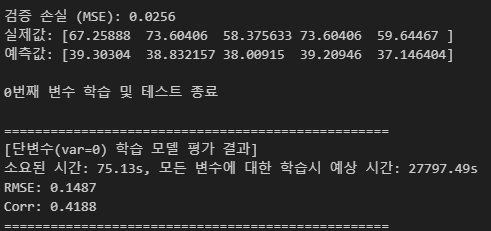
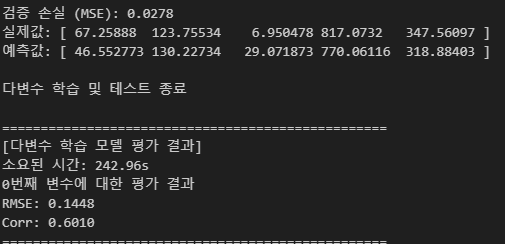